# 네이버 영화리뷰 감성 분석
[데이터셋 링크](https://github.com/e9t/nsmc)

## 데이터 import

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Data Loader 만들기

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        # 토큰화
        temp_X = tokenizer.morphs(sentence) 
        # Stopwords 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        # Tokenization
        temp_X = tokenizer.morphs(sentence)
        # Stopwords 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 사전 인덱스 스트링으로 변환
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델구성을 위한 데이터 분석 및 가공

In [6]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
# padding을 문장 뒤,앞 중 어디로 하느냐에 따라 RNN 성능 차이남.
      
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='post', # 혹은 'pre'
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='post', # 혹은 'pre'
                                                    maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델구성 및 validation set 구성

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.SpatialDropout1D(0.4))
lstm_model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
lstm_model.add(keras.layers.Dense(8, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 16)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                13400     
_________________________________________________________________
dense (Dense)                (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 173,817
Trainable params: 173,817
Non-trainable params: 0
_________________________________________________________________


In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

gru_model = keras.Sequential()
gru_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gru_model.add(keras.layers.GRU(50))   # 가장 널리 쓰이는 RNN인 gru 레이어를 사용하였습니다. 이때 gru state 벡터의 차원수는 8로 하였습니다. (변경가능)
gru_model.add(keras.layers.Dropout(0.3))
gru_model.add(keras.layers.Dense(8, activation='relu'))
gru_model.add(keras.layers.Dropout(0.3))
gru_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru (GRU)                    (None, 50)                10200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 170,617
Trainable params: 170,617
Non-trainable params: 0
________________________________________________

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dropout(0.3))
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dropout(0.3))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          7184      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

global_l_model = keras.Sequential()
global_l_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
global_l_model.add(keras.layers.GlobalMaxPooling1D())
global_l_model.add(keras.layers.Dropout(0.3))
global_l_model.add(keras.layers.Dense(8, activation='relu'))
global_l_model.add(keras.layers.Dropout(0.3))
global_l_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

global_l_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
________________________________________________

In [12]:
cnn_lstm_model = keras.Sequential()
cnn_lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_lstm_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_lstm_model.add(keras.layers.MaxPooling1D(5))
cnn_lstm_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_lstm_model.add(keras.layers.SpatialDropout1D(0.4))
cnn_lstm_model.add(keras.layers.LSTM(10, dropout=0.2, recurrent_dropout=0.2))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
cnn_lstm_model.add(keras.layers.Dense(8, activation='relu'))
cnn_lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1080      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [13]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 훈련 개시

In [14]:
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

lstm_history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/30
266/266 [==============================] - 19s 71ms/step - loss: 0.5071 - accuracy: 0.7267 - val_loss: 0.3677 - val_accuracy: 0.8385
Epoch 2/30
266/266 [==============================] - 19s 70ms/step - loss: 0.3713 - accuracy: 0.8397 - val_loss: 0.3487 - val_accuracy: 0.8484
Epoch 3/30
266/266 [==============================] - 19s 70ms/step - loss: 0.3476 - accuracy: 0.8535 - val_loss: 0.3467 - val_accuracy: 0.8516
Epoch 4/30
266/266 [==============================] - 19s 70ms/step - loss: 0.3349 - accuracy: 0.8591 - val_loss: 0.3543 - val_accuracy: 0.8476
Epoch 5/30
266/266 [==============================] - 19s 70ms/step - loss: 0.3242 - accuracy: 0.8638 - val_loss: 0.3411 - val_accuracy: 0.8534
Epoch 6/30
266/266 [==============================] - 19s 70ms/step - loss: 0.3180 - accuracy: 0.8660 - val_loss: 0.3431 - val_accuracy: 0.8511
Epoch 7/30
266/266 [==============================] - 19s 70ms/step - loss: 0.3109 - accuracy: 0.8683 - val_loss: 0.3363 - val_accuracy:

In [15]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history = cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 7s 27ms/step - loss: 0.4876 - accuracy: 0.7596 - val_loss: 0.3410 - val_accuracy: 0.8491
Epoch 2/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3527 - accuracy: 0.8616 - val_loss: 0.3258 - val_accuracy: 0.8562
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3069 - accuracy: 0.8826 - val_loss: 0.3243 - val_accuracy: 0.8609
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2581 - accuracy: 0.9043 - val_loss: 0.3480 - val_accuracy: 0.8538
Epoch 5/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2103 - accuracy: 0.9252 - val_loss: 0.3858 - val_accuracy: 0.8493
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1634 - accuracy: 0.9451 - val_loss: 0.4535 - val_accuracy: 0.8420
Epoch 7/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1268 - accuracy: 0.9587 - val_loss: 0.5686 - val_accuracy: 0.8408
Epoch

In [16]:
global_l_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

global_l_history = global_l_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6306 - accuracy: 0.6622 - val_loss: 0.4844 - val_accuracy: 0.8155
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.4701 - accuracy: 0.8029 - val_loss: 0.3919 - val_accuracy: 0.8356
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.4202 - accuracy: 0.8286 - val_loss: 0.3723 - val_accuracy: 0.8403
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3947 - accuracy: 0.8401 - val_loss: 0.3637 - val_accuracy: 0.8417
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3785 - accuracy: 0.8472 - val_loss: 0.3596 - val_accuracy: 0.8462
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3653 - accuracy: 0.8516 - val_loss: 0.3592 - val_accuracy: 0.8456
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3555 - accuracy: 0.8570 - val_loss: 0.3582 - val_accuracy: 0.8456
Epoch 

In [17]:
cnn_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_lstm_history = cnn_lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 7s 27ms/step - loss: 0.5284 - accuracy: 0.7191 - val_loss: 0.3567 - val_accuracy: 0.8445
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3581 - accuracy: 0.8500 - val_loss: 0.3442 - val_accuracy: 0.8507
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3285 - accuracy: 0.8635 - val_loss: 0.3408 - val_accuracy: 0.8532
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3101 - accuracy: 0.8728 - val_loss: 0.3379 - val_accuracy: 0.8554
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2923 - accuracy: 0.8823 - val_loss: 0.3375 - val_accuracy: 0.8515
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2730 - accuracy: 0.8920 - val_loss: 0.3478 - val_accuracy: 0.8540
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2520 - accuracy: 0.9037 - val_loss: 0.3597 - val_accuracy: 0.8507
Epoch

In [18]:
gru_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gru_history = gru_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.6226 - accuracy: 0.5943 - val_loss: 0.3893 - val_accuracy: 0.8317
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3799 - accuracy: 0.8435 - val_loss: 0.3511 - val_accuracy: 0.8456
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3506 - accuracy: 0.8591 - val_loss: 0.3519 - val_accuracy: 0.8496
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3372 - accuracy: 0.8657 - val_loss: 0.3457 - val_accuracy: 0.8497
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3292 - accuracy: 0.8677 - val_loss: 0.3366 - val_accuracy: 0.8519
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3194 - accuracy: 0.8730 - val_loss: 0.3397 - val_accuracy: 0.8518
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3084 - accuracy: 0.8769 - val_loss: 0.3397 - val_accuracy: 0.8568
Epoch 

## Loss, Accuracy 그래프 시각화

In [19]:
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
cnn_results = cnn_model.evaluate(X_test,  y_test, verbose=2)
global_l_results = global_l_model.evaluate(X_test,  y_test, verbose=2)
cnn_lstm_results = cnn_lstm_model.evaluate(X_test,  y_test, verbose=2)
gru_results = gru_model.evaluate(X_test,  y_test, verbose=2)
# feed_results = feed_model.evaluate(X_test,  y_test, verbose=2)

print("LSTM: ",lstm_results)
print("CNN: ",cnn_results)
print("GlobalMaxPooling1D() 레이어 하나만: ",global_l_results)
print("CNN-LSTM: ",cnn_lstm_results)
print("gru network: ",gru_results)
# print("transformer: ",cnn_lstm_results)

1537/1537 - 12s - loss: 0.3810 - accuracy: 0.8514
1537/1537 - 3s - loss: 0.7832 - accuracy: 0.8386
1537/1537 - 1s - loss: 0.3867 - accuracy: 0.8386
1537/1537 - 4s - loss: 0.4344 - accuracy: 0.8410
1537/1537 - 2s - loss: 0.4780 - accuracy: 0.8391
LSTM:  [0.38103875517845154, 0.851394534111023]
CNN:  [0.783225417137146, 0.8385580778121948]
GlobalMaxPooling1D() 레이어 하나만:  [0.38669446110725403, 0.8385784029960632]
CNN-LSTM:  [0.43440237641334534, 0.8409585356712341]
gru network:  [0.47800058126449585, 0.8391073346138]


/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

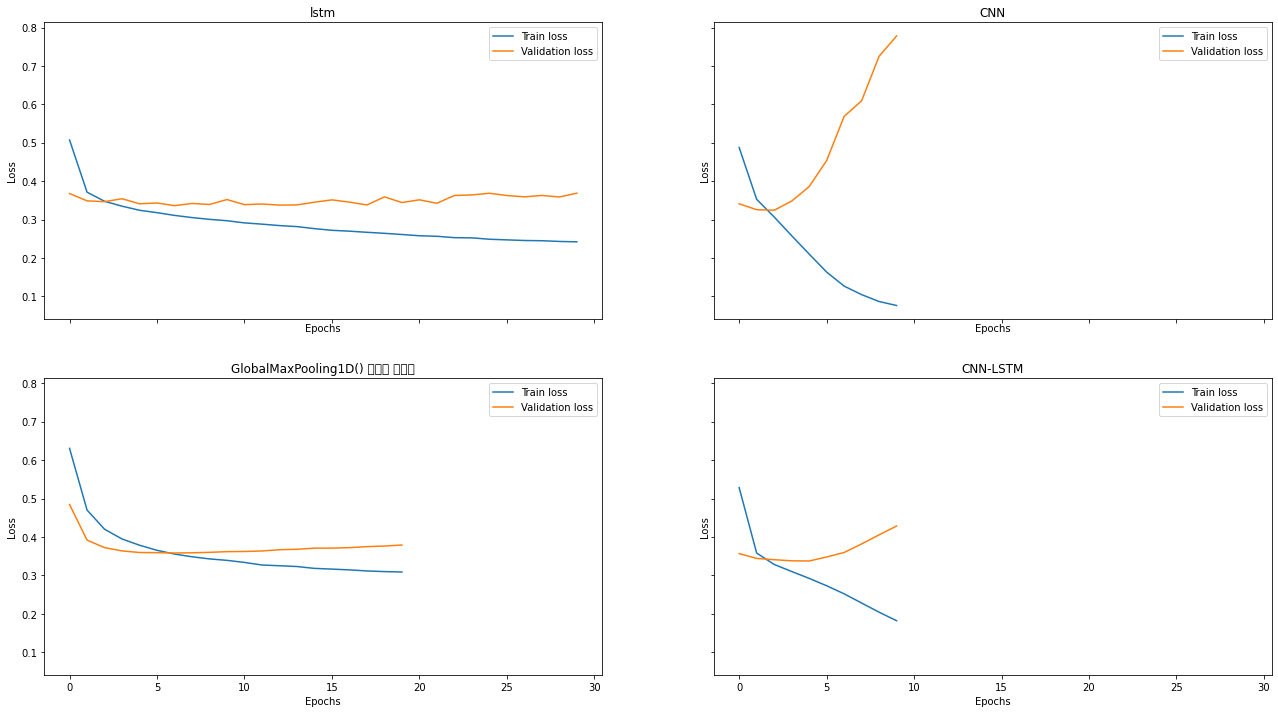

In [20]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
# ax5 = axes[2]

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('lstm')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(global_l_history.history['loss'], label='Train loss')
ax3.plot(global_l_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('GlobalMaxPooling1D() 레이어 하나만')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')

# ax5.plot(gru_history.history['loss'], label='Train loss')
# ax5.plot(gru_history.history['val_loss'], label='Validation loss')
# ax5.legend(loc='best')
# ax5.set_title('GRU')
# ax5.set_xlabel('Epochs')
# ax5.set_ylabel('Loss')

plt.show()

## 학습된 Embedding 레이어 분석

In [21]:
embedding_layer = global_l_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [22]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_kor.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = global_l_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [23]:
# embedding parameter 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.26964158, -0.2027828 , -0.29704815, -0.24656129, -0.24768768,
       -0.15116838, -0.29230902, -0.22323614, -0.14989823, -0.2137274 ,
       -0.2640676 , -0.12096033, -0.27374282, -0.27285323, -0.27633062,
       -0.23739438], dtype=float32)

In [24]:
word_vectors.similar_by_word("재미없")

[('대충', 0.9705683588981628),
 ('못생겼', 0.9604666233062744),
 ('한심', 0.9544970393180847),
 ('시시', 0.9498728513717651),
 ('제멋대로', 0.9467077851295471),
 ('과분', 0.9401426315307617),
 ('평이', 0.9374074935913086),
 ('아베', 0.9369668364524841),
 ('글쎄', 0.9358007907867432),
 ('짐작', 0.931463897228241)]

In [25]:
word_vectors.similar_by_word("지루")

[('뻔해', 0.9801760911941528),
 ('엥', 0.9689817428588867),
 ('꺼지', 0.9654102325439453),
 ('버려라', 0.9574466943740845),
 ('과분', 0.9530490040779114),
 ('빨', 0.9520505666732788),
 ('구려', 0.9422466158866882),
 ('시시', 0.9420030117034912),
 ('꺼라', 0.9374504089355469),
 ('건조', 0.9374461770057678)]

In [26]:
word_vectors.similar_by_word("감동")

[('죠', 0.9465866088867188),
 ('의상', 0.9463531374931335),
 ('~!!!', 0.9414889812469482),
 ('쉬', 0.9413456320762634),
 ('그리고', 0.9400491714477539),
 ('된다면', 0.936847448348999),
 ('전성기', 0.9286718368530273),
 ('풀', 0.9283691644668579),
 ('추억', 0.9278419017791748),
 ('던데', 0.9247300028800964)]

## 한국어 Word2Vec 임베딩 활용하여 성능개선
[파일 링크](https://github.com/Kyubyong/wordvectors)

In [27]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [28]:
word2vec.similar_by_word("감동")

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908232569694519),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140127778053284),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [29]:
word2vec.similar_by_word("지루")

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('답답', 0.7367105484008789),
 ('편안', 0.7046725749969482),
 ('솔직', 0.6893644332885742),
 ('쓸쓸', 0.6880697011947632),
 ('차분', 0.6868932843208313),
 ('조용', 0.6765609979629517),
 ('냉정', 0.6706622838973999),
 ('자유분방', 0.6680829524993896),
 ('피곤', 0.6597293019294739),
 ('느긋', 0.659047544002533)]

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [31]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
cnn_model2 = keras.Sequential()
cnn_model2.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
cnn_model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model2.add(keras.layers.MaxPooling1D(5))
cnn_model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model2.add(keras.layers.GlobalMaxPooling1D())
cnn_model2.add(keras.layers.Dense(8, activation='relu'))
cnn_model2.add(keras.layers.Dropout(0.3))
cnn_model2.add(keras.layers.Dense(1, activation='sigmoid')) 

print(cnn_model2.summary())

# 학습의 진행
cnn_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_history2 = cnn_model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = cnn_model2.evaluate(X_test,  y_test, verbose=2)

print(results)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                

In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
gru_model2 = keras.Sequential()
gru_model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gru_model2.add(keras.layers.GRU(50))   # 가장 널리 쓰이는 RNN인 gru 레이어를 사용하였습니다. 이때 gru state 벡터의 차원수는 8로 하였습니다. (변경가능)
gru_model2.add(keras.layers.Dropout(0.3))
gru_model2.add(keras.layers.Dense(8, activation='relu'))
gru_model2.add(keras.layers.Dropout(0.3))
gru_model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

print(gru_model2.summary())

# 학습의 진행
gru_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gru_history2 = gru_model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = gru_model2.evaluate(X_test,  y_test, verbose=2)

print(results)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                37800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 408       
_________________________________________________________________
dropout_8 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,038,217
Trainable params: 2,038,217
Non-trainable params: 0
____________________________________________

In [36]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
lstm_model2 = keras.Sequential()
lstm_model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model2.add(keras.layers.SpatialDropout1D(0.4))
lstm_model2.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
lstm_model2.add(keras.layers.Dense(8, activation='relu'))
lstm_model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

print(lstm_model2.summary())

# 학습의 진행
lstm_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

lstm_history2 = lstm_model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = lstm_model2.evaluate(X_test,  y_test, verbose=2)

print(results)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, None, 200)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 408       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 2,050,617
Trainable params: 2,050,617
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
266/266 [==============================] - 24s 88ms/step - loss: 0.4839 - accuracy: 0.7401 - 

In [35]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
cnn_lstm_model2 = keras.Sequential()
cnn_lstm_model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_lstm_model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_lstm_model2.add(keras.layers.MaxPooling1D(5))
cnn_lstm_model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_lstm_model2.add(keras.layers.SpatialDropout1D(0.4))
cnn_lstm_model2.add(keras.layers.LSTM(15, dropout=0.2, recurrent_dropout=0.2))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
cnn_lstm_model2.add(keras.layers.Dense(8, activation='relu'))
cnn_lstm_model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
print(cnn_lstm_model2.summary())

# 학습의 진행
cnn_lstm_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cnn_lstm_history2 = cnn_lstm_model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = cnn_lstm_model2.evaluate(X_test,  y_test, verbose=2)

print(results)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, None, 16)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15)                1920      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                